In [4]:
using JLBrainPhysio
using JLBrainPhysio.ModelingToolkit #needed to define time
using JLBrainPhysio.DifferentialEquations #needed to solve the system of equations
using Plots

# Todo : 

- [ ] Verifier les parameters
- [ ] Essayer avec compliance nulle pour les veines dans la version Python, ou ajouter la compliance ici


Callback functions
https://discourse.julialang.org/t/update-parameters-in-modelingtoolkit-using-callbacks/63770/8

### Variables

In [5]:
meanPa=100 #mmHg
Pdiastole=75 #mmHg [from patient]
Psystole=125 #mmHg [from patient]


#Arteries
Ca=5e-3 *10  #ml / mmHg [Parameter] ## pourquoi ? a t on bien tout les forcages present car peu de pulsatilité sur CSF pressure
Pan = meanPa #mmHg 
Pcn= 25 #mmHg [Parameter] ou Ran [Parameter]
qan= 12.5 #ml/s [Input from patient]


Ran=(Pan-Pcn)/qan

Pvn=14 #mmHg [Parameter] ou Rc [Parameter]

Rc=(Pcn-Pvn)/qan

Ev=1.1e6*0.00075 #mmHg
Ea=8e6*0.00075 #mmHg
ratio_d_h_v=66
ratio_d_h_a=8
ratio_Vv_Va=0.72/(1-0.72)

Cv=Ca*ratio_Vv_Va*Ea/Ev*ratio_d_h_v/ratio_d_h_a

Pvsn=6.0 #mmHg  Erreur dans ursino [Parameter] ou Rvsn [Parameter]

Rvsn=(Pvn-Pvsn)/qan

Picn=10 #mmHg [From patient]

Rvs_nc=Rvsn*(Pvn-Picn)/(Pvn-Pvsn)

Ccv=2.34 #ml/mmHg [Parameter]

Pcv=4 #mmHg [Parameter] ou Rcv [Parameter]

Rcv=(Pvsn-Pcv)/(qan)


R0=8.75*60 #mmHg s/ml [Parameter]

qon=(Picn-Pvsn)/R0

qp_a=0.9*qon # ml/s [parameter]

Rp=((Pcn+Pvn)/2-Picn)/(qon-qp_a)

E_CSF=0.26 # cm-3 [Parameter]
C_CSF=1/E_CSF/10  # !!! pourquoi ? necessaire pour avoir une pulsatilité ok, mais pourquoi ?

P0=0 # mmHg [Parameter]

### Saline injection parameters
Iinf=1.5/60 ;#cm3/sec [Fixed]

In [6]:
@variables t;

In [7]:
f=1
off_set=meanPa
amplitude=Psystole-Pdiastole
cose(t) = smooth_cos(t, 5, f, amplitude, 0, off_set, 0)

cose (generic function with 1 method)

In [8]:
@named inlet_arterial_pressure = DrivenPressure(Factor=1, fun=cose);
#@named inlet_arterial_pressure = ConstantPressure(P=Pan);

In [9]:
@named pext = ConstantPressure(P=P0);

In [10]:
@named outlet_venous = WK2BC(R=Rcv,C=Ccv,P=Pcv);

In [11]:
@named capillaries=Exchange_Vessel(Qe=qp_a,Re=Rp,R=Rc);

In [12]:
@named arteries=Linear_Vessel(C₀=Ca, R=Ran);

In [13]:
@component function CSFCompliance(; name, C₀=1.0, V₀=1.0)
        @named in = Pin()
        @named out = Pin()
        @named ext = Pin()
    
        ps = @parameters begin
            C₀ = C₀
            V₀ = V₀
        end
     
        sts = @variables begin
            V(t) = V₀
            p_ext(t) = 0.0
            p(t) = 0.0
            C(t)=C₀
        end
    
    
        D = Differential(t)
    
        eqs = [ C ~ C₀/(in.p-p_ext+1e-6)
                out.p~in.p
                p ~ in.p
                p_ext ~ ext.p
                D(V) ~ in.q+out.q
                (D(p)-D(p_ext)) ~ (in.q+out.q)/C₀  
        ]
    
    
    
        compose(ODESystem(eqs, t, sts, ps; name=name), in, out,ext)
        
end 

CSFCompliance (generic function with 1 method)

In [14]:
C_CSF


0.3846153846153846

In [15]:
#@named CSF_global = Linear_Compliance(C₀=C_CSF)
#@named CSF_global = Compliance(C=C_CSF, inP=true
@named CSF_global = CSFCompliance(C₀=C_CSF)

Model CSF_global with 6 (9) equations
States (10):
  V(t) [defaults to V₀]
  p_ext(t) [defaults to 0.0]
  p(t) [defaults to 0.0]
  C(t) [defaults to C₀]
  in₊p(t) [defaults to 1.0]
  in₊q(t) [defaults to 1.0]
⋮
Parameters (2):
  C₀ [defaults to 0.384615]
  V₀ [defaults to 1.0]

In [16]:
@named CSF_injection = ConstantFlow(Q=-Iinf)

Model CSF_injection with 1 (2) equations
States (2):
  node₊p(t) [defaults to 1.0]
  node₊q(t) [defaults to 1.0]
Parameters (1):
  Q [defaults to -0.025]

In [17]:
@component function CerebralFlowRegulation(; name, τ=2, P_an=100, P_vn=20)
    @named pin_art = Pin()
    @named pin_ven = Pin()


    sts = @variables begin
        x(t) = 0
    end

    # No parameters in this function
    # Parameters are inherited from subcomponents
    ps = @parameters τ = τ P_an= P_an P_vn = P_vn


    D = Differential(t)

    eqs = [
            D(x) ~ -1/τ *x+1/ τ*((pin_art.p-pin_ven.p-P_an+P_vn)/(P_an-P_vn)),
            pin_art.q ~ 0,
            pin_ven.q ~ 0
    ]

    # and finaly compose the system
    compose(ODESystem(eqs, t, sts, ps; name=name), pin_art, pin_ven)
end

CerebralFlowRegulation (generic function with 1 method)

In [18]:
@named CFR=CerebralFlowRegulation(τ=2, P_an=Pan, P_vn=Pvn) ;

In [19]:
@component function StarlingResistance(; name, R_noncollapsed=1)
        @named in = Pin()
        @named out = Pin()
        @named ext = Pin()       
    
        ps = @parameters R_noncollapsed = R_noncollapsed
    
        sts = @variables begin
            R(t) = 1
        end
    
        eqs = [
                R ~ (in.p-out.p)/(in.p-ext.p+1e-6)*R_noncollapsed
                in.q ~ (in.p-out.p) / R 
                out.q ~ - in.q
                ext.q ~ 0
        ]
        compose(ODESystem(eqs, t, sts, ps; name=name), in,out,ext)
end

StarlingResistance (generic function with 1 method)

In [20]:
@named veins=StarlingResistance(R_noncollapsed=Rvs_nc);

In [22]:
@named CSF_drainage=ResistorValve(R=R0);

In [23]:
elements= [inlet_arterial_pressure,arteries,capillaries,veins,outlet_venous,pext,CSF_global,CSF_drainage,CFR,CSF_injection]
assembly = [
        connect(inlet_arterial_pressure.node, arteries.in)
        connect(arteries.out, capillaries.in)
        connect(capillaries.out,veins.in)
        connect(veins.out,outlet_venous.node)
        connect(veins.ext,CSF_global.in)
        connect(capillaries.ext,CSF_global.in)
        connect(arteries.ext, CSF_global.in)
        connect(CSF_global.ext, pext.node)
        connect(CSF_global.out, CSF_drainage.in)
        connect(CSF_drainage.out,outlet_venous.node)
        connect(arteries.in,CFR.pin_art)
        connect(veins.in,CFR.pin_ven)
        connect(CSF_injection.node,CSF_global.in)
    ];

In [24]:
## Compose the whole ODAE system
@named _model = ODESystem(assembly, t);
@named model = compose(_model, elements);

In [25]:
## And simplify it
sys = structural_simplify(model);

In [26]:
states(sys)

7-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 arteries₊Ca₊V(t)
 CSF_global₊p(t)
 arteries₊Ca₊p(t)
 outlet_venous₊C₊Δp(t)
 CSF_global₊V(t)
 CFR₊x(t)
 CFR₊pin_ven₊p(t)

In [27]:
u0=[arteries.Ca.V => 100,
    CSF_global.p => Picn,
    CSF_global.V => 100,
    veins.in.p => Pvn,
    veins.out.p => Pvsn,
    arteries.Ca.p=> (Pan+Pcn)/2,
    outlet_venous.C.Δp => Pcv-Pvsn,
    outlet_venous.C.q=> 0,
    CFR.x=>0,
    CFR.pin_ven.p => Pvn,
    capillaries.passive_drainage.q =>qon-qp_a]

11-element Vector{Pair{Num, Float64}}:
                  arteries₊Ca₊V(t) => 100.0
                   CSF_global₊p(t) => 10.0
                   CSF_global₊V(t) => 100.0
                     veins₊in₊p(t) => 14.0
                    veins₊out₊p(t) => 6.0
                  arteries₊Ca₊p(t) => 62.5
             outlet_venous₊C₊Δp(t) => -2.0
              outlet_venous₊C₊q(t) => 0.0
                          CFR₊x(t) => 0.0
                  CFR₊pin_ven₊p(t) => 14.0
 capillaries₊passive_drainage₊q(t) => 0.0007619047619047614

In [28]:
prob = ODAEProblem(sys,u0, (0, 60*20), saveat = 1)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 1200)
u0: 6-element Vector{Float64}:
 100.0
  10.0
  62.5
  -2.0
 100.0
   0.0

# Callback functions

"""
`CollapsingVessel(; Rpv=Constant, Rvs'=Constant, Rvs''=Variable, Cv=Constant, Pv, Pvs, Pic)`

Implements the behavior of the venous vascular bed, particularly focusing on the collapsing veins phenomenon observed in the distal intracranial venous vascular bed before entering the dural sinuses.

This component is based on the understanding that while the proximal portion of the venous vascular bed does not collapse due to pressure always being higher than the Intracranial Pressure (ICP), the distal segment is subject to collapse immediately before entering the dural sinuses.

Parameters are in the cm, g, s system.
Pressure in mmHg.
Flow rate is calculated in cm^3/s (ml/s).

`Pv`: Pressure at the entrance of the distal veins. A key parameter in determining the onset of vein collapse.

`Pvs`: Pressure at the outlet of the distal veins, i.e., in the venous sinus. Influences the venous return and the overall resistance faced by the venous blood before entering the dural sinuses.

`Pic`: Intracranial pressure. Acts as the extravascular pressure that influences the collapsing mechanism of the veins.


The resistance of the distal venous bed (`Rvs`) is calculated as `Rvs=(Pv-Pvs)/(Pv-Pic)Rvs'`, reflecting the impact of intraluminal and extravascular pressures on venous resistance immediately upstream of the collapse point.

Note: The model assumes an immediate collapse of the distal venous bed segment before the dural sinuses, with `Rvs''` adapting based on intraluminal pressure conditions.


Named parameters:

`Rpv`: Resistance of the proximal venous vascular bed. Kept constant throughout simulations as per Nakagawa et al. (32).

`Rvs'`: Resistance of the distal intracranial venous vascular bed (portion upstream of the collapse). Kept constant due to negligible changes in the venous lumen diameter as noted by Yada et al. (47).

`Rvs''`: Resistance of the distal intracranial venous vascular bed (portion downstream of the collapse). This is variable and accounts for all the variability in `Rvs` due to the collapsing mechanism.

`Cv`: Intracranial venous compliance. Represents the capacity of the venous system to accommodate blood volume changes.


"""


In [29]:
#Function to recover variables from the initial model from the variables of the simplified system

pic_fun = prob.f.observed(CSF_global.out.p)
pvs_fun = prob.f.observed(veins.out.p)
pv_fun = prob.f.observed(veins.in.p)
x_fun= prob.f.observed(CFR.x)

# get the index of the parameters of interests
indexof(sym, syms) = findfirst(isequal(sym), syms)

# index of the vein resistance, to be modified by the collapsing vein affect function
index_Rveins=indexof(veins.R, parameters(sys))

# index of the arteries resistance, to be modified by the Cerebral Flow Regulation (CFR) affect function
index_Rarteriesc=indexof(arteries.Rc.R, parameters(sys));
index_Rarteriesp=indexof(arteries.Rp.R, parameters(sys));

In [30]:
function collapsing_resistance(u, p, t)
# instable en callback, implementé comme object starling resistor à la place    
    pic=pic_fun(u, p, t)
    pv=pv_fun(u, p, t)
    pvs=pvs_fun(u, p, t)

    #R=Rvsn+Rvsn*t*5/300
    R=(pv-pvs)/(pv-pic)*Rvs_nc

    return R
end

condition_everytimestep(u, t, integrator) =  integrator.iter % 100 == 0
#condition_continuous(u, t, integrator) = t-1e-3

function affect_collapsingveins!(integrator)
    integrator.p[index_Rveins] = collapsing_resistance(integrator.u, integrator.p, integrator.t)
end

callback_veins = DiscreteCallback(condition_everytimestep, affect_collapsingveins!)
#callback_veins = ContinuousCallback(condition_continuous, affect_collapsingveins!)



DiscreteCallback{typeof(condition_everytimestep), typeof(affect_collapsingveins!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition_everytimestep, affect_collapsingveins!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [31]:
function cerebral_arteries_resistance(u, p, t)
    
    x=x_fun(u, p, t)
    
    R=Ran /(1-1/ π *atan(x*π))
    
    return R
end
    
function affect_CRF!(integrator)
    integrator.p[index_Rarteriesc] = cerebral_arteries_resistance(integrator.u, integrator.p, integrator.t)/2
    integrator.p[index_Rarteriesp] = cerebral_arteries_resistance(integrator.u, integrator.p, integrator.t)/2

end

callback_arteries = DiscreteCallback(condition_everytimestep, affect_CRF!)


DiscreteCallback{typeof(condition_everytimestep), typeof(affect_CRF!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition_everytimestep, affect_CRF!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

In [32]:
callback_set=CallbackSet(callback_arteries);

In [33]:
prob = ODAEProblem(sys,u0, (0, 10), saveat = 0.01);
sol1 = solve(prob,Tsit5(),callback=callback_set);

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


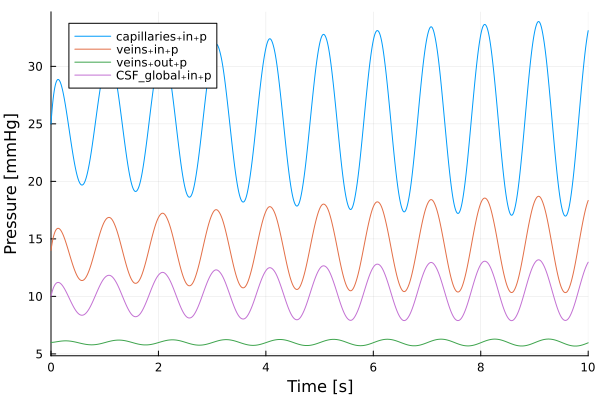

In [34]:
plot(sol1, vars = [capillaries.in.p,veins.in.p,veins.out.p,CSF_global.in.p])
p1 = plot(sol1, idxs=[capillaries.in.p,veins.in.p,veins.out.p,CSF_global.in.p], xlabel = "Time [s]", ylabel = "Pressure [mmHg]",  hidexaxis = nothing) # Make a line plot

img = plot(p1; layout=@layout([a b; c d]), legend = true)

#img = DisplayAs.Text(DisplayAs.PNG(img))

img

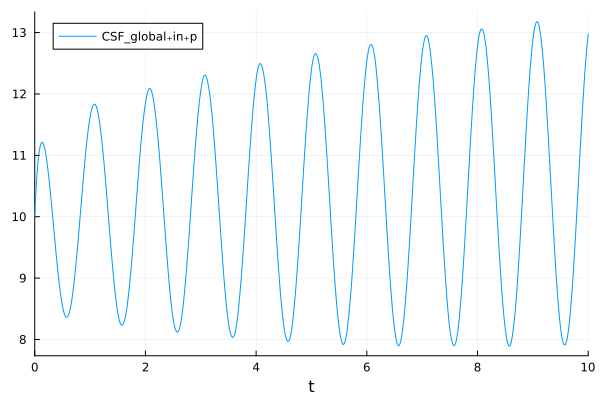

In [35]:
plot(sol1, vars = [CSF_global.in.p])
#plot!([0,60],[Pan,Pan])

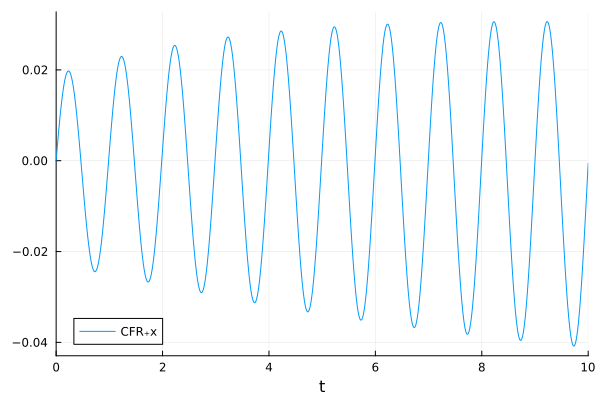

In [36]:
plot(sol1, vars = [CFR.x])

In [38]:
D = Differential(t)
prob = DAEProblem(sys, D.(states(sys)) .=> 0.0, u0, (0.0, 10.0), [])
sol2 = solve(prob, DFBDF(), callback=callback_set);

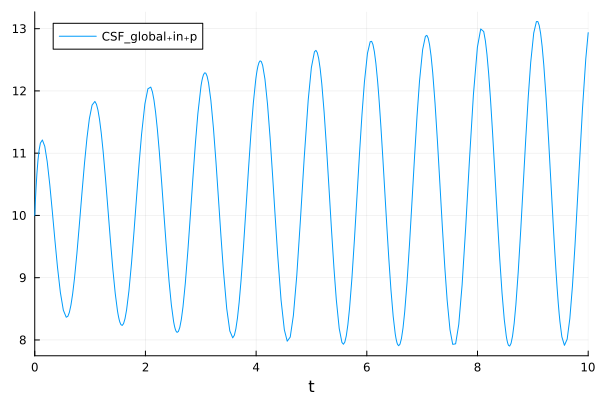

In [39]:
plot(sol2, vars = [CSF_global.in.p])